## Imports

In [32]:
import os
import multiprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import cv2
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

## Preprocessing Methods

In [2]:
def applyClahe(image, clip_limit=2.0, tile_grid_size=(8,8)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    clahe = cv2.createCLAHE(clip_limit, tile_grid_size)
    hsv_image[:,:,2] = clahe.apply(hsv_image[:,:,2])
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def resize_image(image, size=(150, 150)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def blur_image(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

## Prepare Data

In [3]:
def get_list_files(directory):
    all_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            fullPath = os.path.join(root, file)
            all_files.append(fullPath)
    return all_files

def process_image(args):
    image_path, preprocessing_methods = args
    image = cv2.imread(image_path)
    for method in preprocessing_methods:
        image = method(image)

    label = os.path.basename(os.path.dirname(image_path))
    return image, label

def prepare_data(dataset, preprocessing_methods=None):
    if preprocessing_methods is None:
        return

    args = [(image_path, preprocessing_methods) for image_path in dataset]
    num_workers = os.cpu_count() - 1

    with multiprocessing.Pool(num_workers) as pool:
        results = pool.map(process_image, args)

    data = [res[0] for res in results]
    labels = [res[1] for res in results]

    return np.array(data), np.array(labels)

## Feature Extraction

In [4]:
def extract_histogram_features(images, hist_bins=16):
    all_features = []

    for i, image in enumerate(images):
        if image.ndim == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        h_hist = cv2.calcHist([hsv_image], [0], None, [hist_bins], [0, 180])
        s_hist = cv2.calcHist([hsv_image], [1], None, [hist_bins], [0, 256])
        v_hist = cv2.calcHist([hsv_image], [2], None, [hist_bins], [0, 256])

        h_hist = cv2.normalize(h_hist, h_hist).flatten()
        s_hist = cv2.normalize(s_hist, s_hist).flatten()
        v_hist = cv2.normalize(v_hist, v_hist).flatten()

        features.extend(h_hist)
        features.extend(s_hist)
        features.extend(v_hist)

        all_features.append(np.array(features))

    return all_features

## Normalization

In [5]:
def min_max_normalize(features):
    scaler = MinMaxScaler()
    return scaler.fit_transform(features)

## Evaluation

In [20]:
# datasets
train_dataset = get_list_files('../dataset/paddy-leaf-disease-main/train')
test_dataset = get_list_files('../dataset/paddy-leaf-disease-main/test')

# methods
preprocess_methods = [resize_image, blur_image, applyClahe]

# data & labels
x_train, y_train = prepare_data(train_dataset, preprocess_methods)
x_test, y_test = prepare_data(test_dataset, preprocess_methods)

In [21]:
# extract features
x_train_hsv = extract_histogram_features(x_train)
x_test_hsv = extract_histogram_features(x_test)

In [22]:
x_train_hsv_normalize = min_max_normalize(x_train_hsv)
x_test_hsv_normalize = min_max_normalize(x_test_hsv)

In [23]:
model = RandomForestClassifier(random_state=42)

In [24]:
model.fit(x_train_hsv_normalize, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Heatmap

In [26]:
def evaluate_cm_heatmap(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=np.unique(y_test), yticklabels=np.unique(y_test)
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

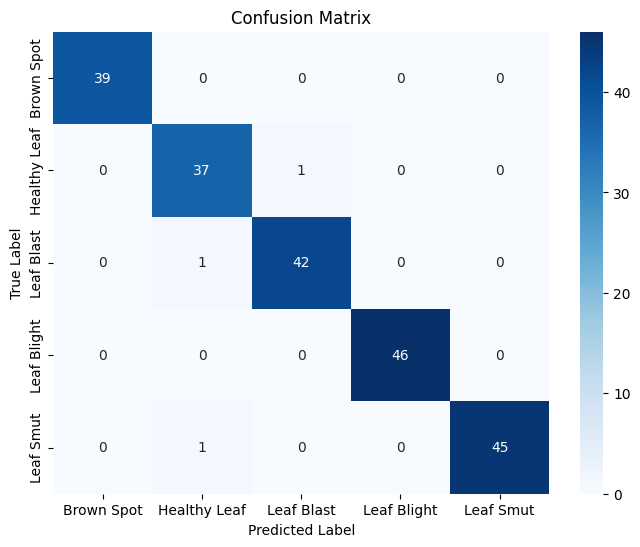

In [27]:
evaluate_cm_heatmap(model, x_test_hsv_normalize, y_test)

### Metrics Visualization

In [30]:
def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    metrics = pd.DataFrame({
        "Score": [accuracy, precision, recall, f1]
    }, index=["Accuracy", "Precision", "Recall", "F1-Score"])

    ax = metrics.plot(kind="bar", legend=False, figsize=(8, 6), colormap="viridis")
    plt.ylabel("Score", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.grid(axis="y")

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=12
        )

    plt.xlabel("")
    plt.tight_layout()
    plt.show()

    return metrics


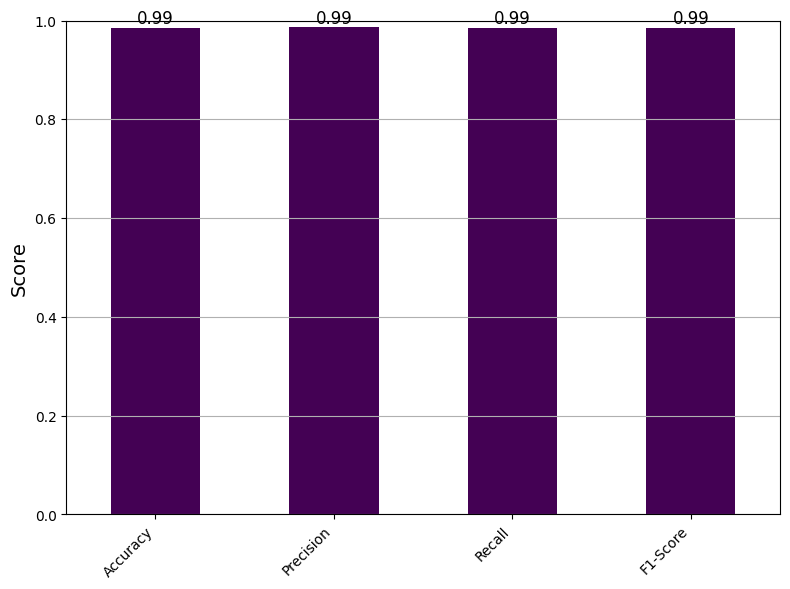

,Score
Accuracy,0.985849
Precision,0.986091
Recall,0.985849
F1-Score,0.985915


In [33]:
calculate_metrics(model, x_test_hsv_normalize, y_test)